<a href="https://colab.research.google.com/github/KarenZhangatUW/CSE517-Final-Project/blob/main/Bert_based_implicit_hate_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Transformers Library

In [2]:
!pip install transformers

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

# Load Dataset

In [4]:
df = pd.read_csv("implicit_hate_v1_stg2_posts.tsv", sep = '\t')
df.head()

,post,implicit_class,extra_implicit_class
0,""" : jewish harvard professor noel ignatiev w...",white_grievance,NaN
1,rt : tune in today's jmt for my interview w /...,irony,NaN
2,: : hate posters ? you want hate buddy ? read ...,white_grievance,NaN
3,: hunt for white women : black racist serial k...,stereotypical,NaN
4,: looks like he was a fan of the islamic jew-h...,stereotypical,NaN


In [5]:
df.shape

(6346, 3)

In [6]:
df = df.rename(columns={"post": "text", "implicit_class": "label"})

In [7]:
# check class distribution
df['label'].value_counts(normalize = True)

white_grievance    0.242357
incitement         0.199968
stereotypical      0.178538
inferiority        0.135991
irony              0.125591
threatening        0.104948
other              0.012606
Name: label, dtype: float64

In [8]:
df['label'] = df['label'].replace(['white_grievance','incitement','stereotypical',"inferiority","irony","threatening","other"],
                     [0,1,2,3,4,5,6]) 

In [9]:
df.head(5)

,text,label,extra_implicit_class
0,""" : jewish harvard professor noel ignatiev w...",0,NaN
1,rt : tune in today's jmt for my interview w /...,4,NaN
2,: : hate posters ? you want hate buddy ? read ...,0,NaN
3,: hunt for white women : black racist serial k...,2,NaN
4,: looks like he was a fan of the islamic jew-h...,2,NaN


# Split train dataset into train, validation and test sets

In [10]:
temp_text, test_text, temp_labels, test_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=101, 
                                                                    train_size=0.80, test_size=0.20,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
train_text, val_text, train_labels, val_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=101, 
                                                                train_size=0.75, test_size=0.25,
                                                                stratify=temp_labels)

In [11]:
val_text.shape

(1269,)

# Import BERT Model and BERT Tokenizer

In [12]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [13]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [14]:
# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

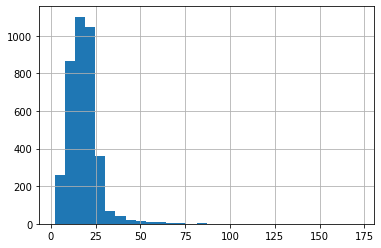

In [15]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [16]:
max_seq_len = 50

In [17]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [18]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [19]:
#define a batch size
batch_size = 8

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [21]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [22]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,32)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(32,7)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [23]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [24]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, eps=1e-08)

# number of training epochs
epochs = 100

# Find Class Weights

In [25]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(train_labels), y = train_labels)

print(class_wts)

[ 0.58922767  0.71466116  0.80096781  1.04991726  1.13777645  1.35964286
 11.33035714]


In [26]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 


# Fine-Tune BERT

In [27]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [28]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    with torch.no_grad():
      preds = model(val_seq.to(device), val_mask.to(device))
      preds = preds.cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    acc = accuracy_score(val_y,preds)
    print(acc)
    if acc > 0.75:
      break


 Epoch 1 / 100
  Batch    50  of    476.
  Batch   100  of    476.
  Batch   150  of    476.
  Batch   200  of    476.
  Batch   250  of    476.
  Batch   300  of    476.
  Batch   350  of    476.
  Batch   400  of    476.
  Batch   450  of    476.

Evaluating...
  Batch    50  of    159.
  Batch   100  of    159.
  Batch   150  of    159.

Training Loss: 1.906
Validation Loss: 1.909
0.2214342001576044

 Epoch 2 / 100
  Batch    50  of    476.
  Batch   100  of    476.
  Batch   150  of    476.
  Batch   200  of    476.
  Batch   250  of    476.
  Batch   300  of    476.
  Batch   350  of    476.
  Batch   400  of    476.
  Batch   450  of    476.

Evaluating...
  Batch    50  of    159.
  Batch   100  of    159.
  Batch   150  of    159.

Training Loss: 1.908
Validation Loss: 1.880
0.24980299448384555

 Epoch 3 / 100
  Batch    50  of    476.
  Batch   100  of    476.
  Batch   150  of    476.
  Batch   200  of    476.
  Batch   250  of    476.
  Batch   300  of    476.
  Batch   350

# Load Saved Model

In [31]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [32]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [33]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.51      0.49      0.50       308
           1       0.55      0.37      0.44       254
           2       0.46      0.55      0.50       227
           3       0.43      0.40      0.42       173
           4       0.53      0.51      0.52       159
           5       0.45      0.73      0.56       133
           6       0.00      0.00      0.00        16

    accuracy                           0.49      1270
   macro avg       0.42      0.44      0.42      1270
weighted avg       0.49      0.49      0.48      1270



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1,2,3,4,5
row_0,,,,,,
0,151,44,62,21,11,19
1,57,95,38,19,10,35
2,47,11,124,17,19,9
3,17,11,17,70,24,34
4,12,5,17,26,81,18
5,2,6,12,9,7,97
6,8,2,0,2,2,2
